In [59]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import sys
from subsp_scripts import tax2table

import statsmodels.api as sm

from collections import defaultdict
import random

from upsetplot import UpSet

In [60]:
# Read sample metadata from CureatedMetagenomicData

metadata = pd.read_csv("../machine_learning/data/2023_curatedmetadata.csv", low_memory=False)
metadata = metadata.loc[metadata['study_condition'] == 'control']
metadata = metadata.loc[metadata['body_site'] == 'stool']
metadata = metadata.loc[metadata['age_category'] == 'adult']

In [61]:
# Prepare Tax table

humgut = pd.read_csv("../benchmark/HumGut.tsv",sep='\t')
humgut['cluster95'] = humgut['cluster95'].astype(str).str.rjust(4,'0')
humgut = humgut[['cluster95','gtdbtk_taxonomy']]

Tax = tax2table(humgut['gtdbtk_taxonomy'])
Tax = Tax.merge(humgut[['cluster95']],left_index=True,right_index=True)

In [5]:
# Read subspecies info

subsp_def = pd.read_csv('../benchmark/fullname_subsp_def_sourmash.txt',sep='\t')
subsp_def['subspecies'] = subsp_def['subspecies'].astype(str).str.rjust(10,'0')
subsp_def['cluster95'] = subsp_def['subspecies'].str[:4]
subsp_def = subsp_def[['subspecies','cluster95']].drop_duplicates()

In [16]:
# Keep only metadata for which we have samples

metadata = metadata.loc[metadata.country.isin(metadata['country'].value_counts().loc[metadata['country'].value_counts() >= 30].index)]

In [7]:
# Read mastiff prevalence table

mastiff = pd.read_csv("mastiff_output_prevalence.csv",index_col=0)

mastiff.columns = mastiff.columns.str.split(".",expand=True).get_level_values(0)
mastiff.columns = mastiff.columns.str.rjust(10,'0')

In [8]:
mastiff = mastiff.loc[mastiff.index.isin(metadata['NCBI_accession'])].T

In [9]:
mastiff = mastiff.T

In [19]:
metadata = metadata.set_index("NCBI_accession")[['country']]

In [20]:
country_continent_mapping = {"USA":"North America", "NLD":"Europe", "GBR":"Europe", "ISR":"Asia","DNK":"Europe", "CHN":"Asia", "DEU":"Europe", "ITA":"Europe",
                            "SWE":"Europe", "JPN":"Asia", "KAZ": "Asia", "IND":"Asia", "FJI": "Australia and Oceania", "CMR": "Africa", "FIN": "Europe",
                            "MNG":"Asia", "MDG": "Africa", "IRL": "Europe", "TZA":"Africa", "ESP":"Europe", "PER": "South America", "CAN":"North America",
                            "SLV": "Europe", "FRA":"Europe", "KOR":"Asia", "LUX":"Europe"}

In [21]:
metadata['continent'] = metadata.country.map(country_continent_mapping)

In [29]:
merged_df = mastiff.merge(metadata, left_index=True, right_index=True, how='inner')

# Calculate the number of occurrences for each subspecies per continent
num_occurrences = merged_df.groupby('continent').sum()

# Calculate the number of samples per continent
num_samples = merged_df['continent'].value_counts()


/var/folders/72/nfvm3kz10tvfvkbqk8st2m48w_nvfh/T/ipykernel_48199/3572358497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  num_occurrences = merged_df.groupby('continent').sum()


In [31]:
prevalence = num_occurrences.T / num_samples

In [32]:
prevalent_subspecies = prevalence.loc[((prevalence > 0.2).sum(1) >= 1)].index
corresponding_species = prevalent_subspecies.str[:4].unique()
corresponding_species = corresponding_species.sort_values()
plot_df = prevalence.loc[prevalence.index.str.startswith(tuple(corresponding_species))]

In [49]:
cluster_phylum = Tax[['cluster95','phylum']].drop_duplicates()
selected_phyla = cluster_phylum.phylum.value_counts().loc[cluster_phylum.phylum.value_counts() > 100].index

In [50]:
def transform_rgb(input_color):
    return (input_color[0]/255,input_color[1]/255,input_color[2]/255)

In [51]:
prevalence_binary = prevalence.mask(prevalence > 0.1, 1)
prevalence_binary = prevalence_binary.mask(prevalence <= 0.1, 0)

In [52]:
prevalence_binary = prevalence_binary.loc[prevalence_binary.sum(1) != 0]

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

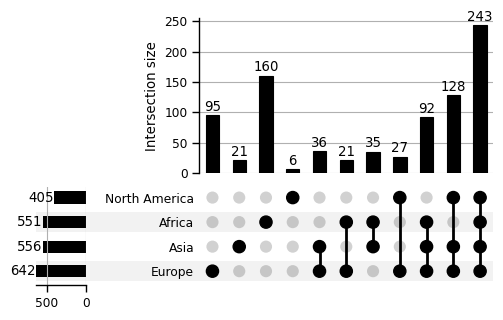

In [53]:
#fig = plt.figure(figsize=(12, 8))
UpSet(prevalence_binary.set_index([*prevalence_binary.columns]),min_subset_size=5, 
                show_counts=True,
               element_size=25,
                #orientation='vertical',
               sort_by='degree',
               show_percentages=False).plot()
#plt.savefig("/Users/trickovi/switchdrive/presentations/figures/AI/figure 2/continents.svg",format='svg')

In [54]:
cluster_phylum = Tax[['cluster95','phylum']].drop_duplicates()
cluster_phylum = cluster_phylum.loc[cluster_phylum.phylum.isin(selected_phyla)]
color_dict = defaultdict()
for phylum in cluster_phylum.phylum.unique():
    color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    color_dict[phylum] = color[0]

color_dict['p__Bacteroidota'] = transform_rgb((47,99,247))
color_dict['p__Firmicutes_A'] = transform_rgb((193,17,206))
color_dict['p__Actinobacteriota'] = transform_rgb((36,41,43))
color_dict['p__Firmicutes'] = transform_rgb((154,185,67))
color_dict['p__Proteobacteria'] = transform_rgb((209,23,27))
color_dict['p__Firmicutes_C'] = transform_rgb((126,36,223))

cluster_phylum['color'] = cluster_phylum['phylum'].map(color_dict)

colors = pd.DataFrame(plot_df.index,columns=['subspecies'])
colors[''] = colors.subspecies.str[:4].map(cluster_phylum[['cluster95','color']].set_index('cluster95').color)
colors = colors.set_index('subspecies')

patches = [mpatches.Patch(color=color, label=label) for label, color in zip(color_dict.keys(), color_dict.values())]

Text(0.5, 1.0, 'Prevalence')

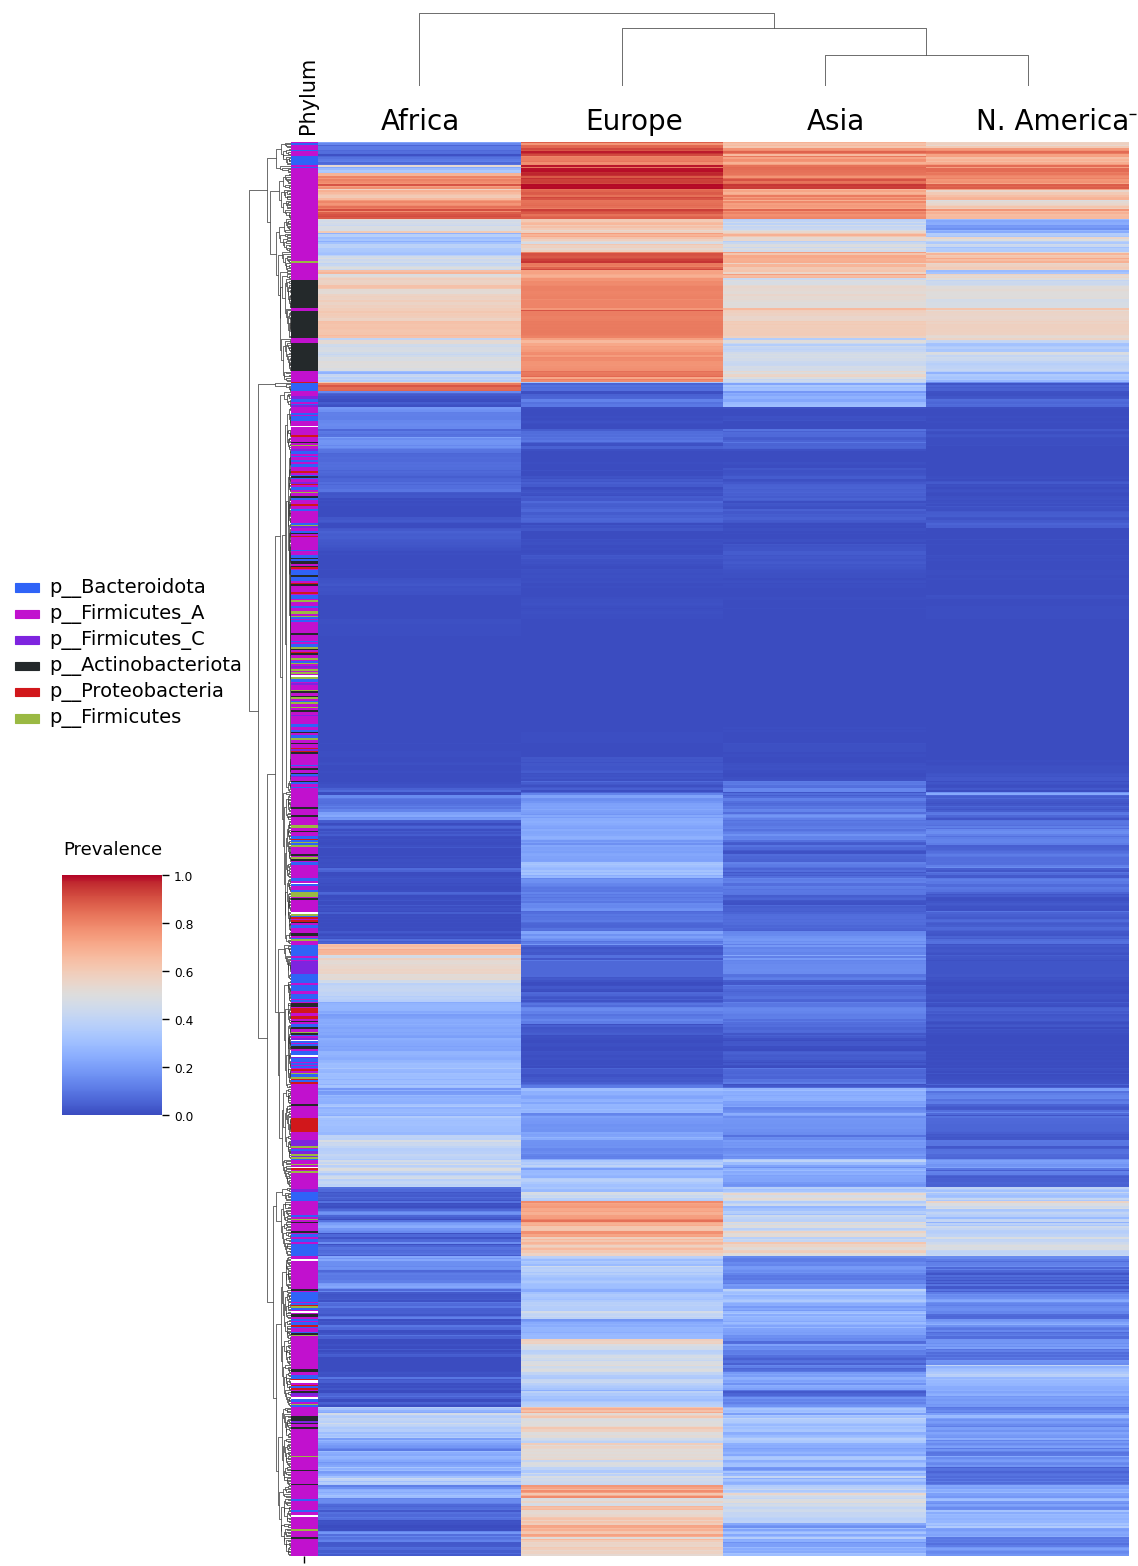

In [56]:
continent_background = pd.DataFrame.from_dict(dict(zip(plot_df.columns, ['white']*plot_df.shape[1])),orient='index',columns=['color'])
continent_background.columns = ['']
sns.set_context('paper')
g = sns.clustermap(plot_df,vmin=0,vmax=1, figsize=(10,16),dendrogram_ratio=0.05,row_colors=colors,
                   col_colors=continent_background, cbar_pos=(-0.17, 0.3, 0.1, 0.15),cmap='coolwarm')

g.ax_heatmap.text(0, -8, "Phylum", fontsize=15, ha='right', rotation=90)

g.ax_heatmap.yaxis.set_ticklabels([])
g.ax_heatmap.yaxis.set_ticks([])

g.ax_heatmap.xaxis.set_ticklabels([])
g.ax_heatmap.xaxis.set_ticks([])

g.ax_heatmap.text(0.7, -8, "Africa", fontsize=20, ha='right')
g.ax_heatmap.text(1.8, -8, "Europe", fontsize=20, ha='right')
g.ax_heatmap.text(2.7, -8, "Asia", fontsize=20, ha='right')
g.ax_heatmap.text(4, -8, "N. America", fontsize=20, ha='right')

legend = g.ax_heatmap.legend(handles=patches, bbox_to_anchor=(-0.08, 0.7), loc=0, borderaxespad=0.5,frameon=False)

for text in legend.get_texts():
    text.set_fontsize(14)
g.cax.set_title("Prevalence", fontsize=13, pad =15)

In [43]:
mastiff = mastiff.replace(True, 1)
mastiff = mastiff.replace(False, 0)

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.sandbox.stats.multicomp import MultiComparison

from tqdm import tqdm

def chi_square_test(df, variable = 'subspecies'):
    # Get a list of subspecies
    subspecies_list = df[variable].unique()
    
    pvals = []
    # Loop over each subspecies
    for subspecies in tqdm(subspecies_list):
        subsp_df = df[df[variable] == subspecies].reset_index().drop_duplicates().set_index('index')
        # Create a contingency table
        contingency_table = pd.crosstab(subsp_df[subsp_df[variable] == subspecies]['country'], 
                                        subsp_df[subsp_df[variable] == subspecies]['presence'])

        # Perform the chi-square test
        chi2, p, dof, ex = chi2_contingency(contingency_table, correction=False)
        pvals.append(p)

    # Correct for multiple testing (BH method)
    reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

    #return pd.DataFrame({'FDR':pvals_corrected}, index=subspecies_list)
    # Print results
    result_list = []
    for subspecies, pval, reject in zip(subspecies_list, pvals_corrected, reject):
        print(f'Variable: {variable}, corrected p-value: {pval}')

        if reject:
            print(f'Significant result for {variable}. Performing post-hoc test...')

            # Subset df for significant subspecies and perform post-hoc test
            df_sub = df[df[variable] == subspecies]
            mc = MultiComparison(df_sub['presence'], df_sub['country'])
            result = mc.tukeyhsd()
            data_rows = result.summary().data
            subsp_results = pd.DataFrame(data_rows[1:],columns = data_rows[0])
            subsp_results[variable] = subspecies
            result_list.append(subsp_results)
    return pd.concat(result_list)

In [28]:
prevalence_df = mastiff.reset_index().melt(id_vars='sample')
prevalence_df = prevalence_df.merge(metadata,left_on = 'sample',right_index=True).reset_index(drop=True)
prevalence_df = prevalence_df.rename(columns={'variable':'subspecies', 'value':'presence'})

In [29]:
temp_df = prevalence_df.loc[prevalence_df.subspecies.str.startswith("0174")]

In [30]:
contingency_table = pd.crosstab(temp_df[temp_df['subspecies'] == '0174001002']['country'], 
                                temp_df[temp_df['subspecies'] == '0174001002']['presence'])

In [31]:
result = chi_square_test(prevalence_df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3038/3038 [36:19<00:00,  1.39it/s]


Variable: subspecies, corrected p-value: 1.0727583358380715e-152
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.564567930946106e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.371650254642444e-142
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.722166266719611e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.45500143524868e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.912259255988008
Variable: subspecies, corrected p-value: 1.9724748033358248e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.087274971577295e-72
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5823203771960789e-259
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2106285738849956e-231
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1769232844160179e-111
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.002597721466840356
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.35485175536297475
Variable: subspecies, corrected p-value: 0.13705788064056554
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.632634304871301e-143
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.505336760626147e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.531983189943326e-113
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9198926582065883
Variable: subspecies, corrected p-value: 7.138892792298826e-231
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00040393864336568777
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.1992546037747626e-180
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0984706780887631
Variable: subspecies, corrected p-value: 8.25013538411818e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.067774785973595e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.7032192482998604e-130
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.624770751632585e-157
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.831138731576323e-151
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.058453100562919816
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.252758056566944e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.5588728551603285e-125
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.672062729407182e-102
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.771690954768066e-31
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.5476196455852873e-06
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.8897185297026833e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.815488969218233e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3192483427019415e-174
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.651084560739483e-12
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.337955700931698e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5660238661069697e-29
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.82844203450999e-41
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.8478547900093483e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7625945787996013e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.350529602558331e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.9670445502544653
Variable: subspecies, corrected p-value: 2.3924416089398965e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6502558372473406e-82
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.315040787003116e-168
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3146502708519806e-221
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7392538616401918e-156
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1671679133675193e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.06372336216119166
Variable: subspecies, corrected p-value: 4.754336953897891e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.869785629860855e-108
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.344272477280639e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.090565092558489e-174
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.701553022784067e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7093428582132104e-67
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.502726070704365e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.046791029132128e-186
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.3642349711609429
Variable: subspecies, corrected p-value: 2.5798929855250454e-291
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0207601527871844e-238
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.444189167000182e-204
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.138739979891463e-06
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.126716329382053e-206
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.032409839609757976
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.568460184638294e-265
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3585513677711627e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.2339227159239201
Variable: subspecies, corrected p-value: 8.592804110267328e-86
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.073154800877266e-155
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.616131530856467e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.7068423355126297e-122
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.4877391070015382e-270
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.021106265368984e-182
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.146883918640899e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.027303089723453e-254
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.2881075955580177e-278
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.115354415448999e-167
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.956995216840488e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5163865936899e-152
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5812639258792648e-89
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.2863793243013337e-192
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.010337394325497e-43
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2176417006842338e-285
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.9264942926147465
Variable: subspecies, corrected p-value: 3.8429948720860217e-112
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.388993284268803e-87
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.518666138861735e-171
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4086832430607533e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.263635949854438e-279
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0323108579731046e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.924472954720374e-92
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5601017466198226e-170
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.766389794884072e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.787867627869442e-170
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.110845630336664e-217
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 8.096442305749574e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.2340586336219192e-174
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.454084460225062e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.5547221543155374e-70
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9021848147540212
Variable: subspecies, corrected p-value: 2.9813266700027766e-241
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3048713269922816e-175
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.692051142029734e-30
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.5225087618871332e-71
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3337756539145942e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.6458123609070186e-55
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.3314332006836445e-195
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.000118596812796e-248
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.113605513707126e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0807416535756429
Variable: subspecies, corrected p-value: 0.2937492037262876
Variable: subspecies, corrected p-value: 5.482952042667462e-162
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.1539708938241953e-193
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.39776212931964e-112
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.69488731747018e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.781940395209071e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.6584344335032498
Variable: subspecies, corrected p-value: 9.341339675039649e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.3615482413663297e-75
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.201228602715784e-119
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.67842472866082e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.92586647215286e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0013102629150727764
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.089897915612628e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.52991272599434e-226
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.355074642339317e-44
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3053919840365703e-114
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.7934383214526068
Variable: subspecies, corrected p-value: 1.4797836347292559e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.4421567597863713e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.236785864204842e-145
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.227700615317916e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.3911123157888025e-94
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.16074125310387322
Variable: subspecies, corrected p-value: 4.4383915687181414e-32
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4966045896251096e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.980193559959108e-173
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.082376755212674e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.307877644714451e-18
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.15091000474257998
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.96115629963911e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0735180167365923e-161
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.531740935203828e-36
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.614040477604114e-187
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.149978679527868e-248
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2032549371932232e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.896935706023838e-34
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.32171487964111e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.488294260889781e-177
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.320090605631463e-179
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.851287479377831e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.6339299827685117e-49
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.8914008163345244e-38
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.2591778629256205e-79
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0287315469870873e-20
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.1254579509131005e-128
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.875762383251224e-187
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.494096950072692e-282
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.430444671673954e-222
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.5776200283361773e-211
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.189832455346879e-100
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.807385608810796e-216
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.025454684430857e-90
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.696093776929367e-67
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.216740041186187e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4512159562093126e-99
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.603572233528205e-201
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.3827914490717326e-297
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.37121052634003e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.396511624853625e-179
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.4191185310525093e-166
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1159898469280394e-101
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.016349398314902987
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.896787760171135e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.972929732281104e-222
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.259288071876762e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.252099011032906e-177
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.123922858014162e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.373043206376975e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0460032181092686e-74
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.9124096840729736e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.983737669868471e-33
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0159457457594048e-80
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.768518885566862e-88
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.672359989784426e-15
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.3602892799103954e-134
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.5228225533982463
Variable: subspecies, corrected p-value: 0.2965571334103604
Variable: subspecies, corrected p-value: 2.1775960315828467e-88
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.780795361707141e-164
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.797971072783645e-140
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.658998628466597e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.692309529075093e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3254311878332963e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3296472213045147e-45
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.0453368387458715e-60
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.961452387597538e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9175675181172696e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.445139498595216e-41
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4904753470063094e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0139184733538413e-29
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.03682164976795718
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2649188508548978e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.2386116228370483e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.448562287083074e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.1081095959842148
Variable: subspecies, corrected p-value: 1.3393661169761594e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.048962941070420964
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.1893864424720606e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.9784278512372386e-32
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.509080653244258e-63
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.375727954821729e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3232887243517794e-86
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2505425444196825e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.545468731470501e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3666349446000508e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2550077316968283e-172
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2608179969909005e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.874741930007041e-37
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.00020024690943791756
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.390952074892445e-09
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.4424553849094858e-34
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2034054905918135e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.073282286074027e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 3.092724257454152e-102
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.8413290713511689
Variable: subspecies, corrected p-value: 2.4098676555078024e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.598202456576191e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.178462925224551e-136
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8592106800250722e-215
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.018692298679603e-68
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.6632558329056065e-164
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9709245369907265e-60
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.1097286342163883e-201
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.286748776077706e-237
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.117069423051831e-301
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.009078249895744553
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4648018473175373e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.3604160493998324e-46
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0083194476013189e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1407053354713783e-35
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.752621655966281e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4313976240097716e-40
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4988927129272557e-192
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0446861524735045
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.6277764508533857e-202
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.9812737452038554e-223
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.290281633197234e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1730309090169245e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.841112512457305e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.810413697746194e-39
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0667835564595387e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.21809098988095e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.387968943315967e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.61111687698898e-233
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00016013500649087758
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.1512793060859426e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.742090768090362e-44
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0543988182741945e-19
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.342123569579128e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.127081776873409e-35
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.463778269380186e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.6595144870036353e-29
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.6970793158509187e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0236486823011388e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.546318174756462e-127
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.059315230827632e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.0127583380673562e-52
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.256302938559526e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.617054778005004e-183
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0434601672596762e-80
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.213624517792517e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.365884181243713e-22
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.2105605363636532e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.250779283834278e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.206794665624165e-79
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.014909670216769264
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.014304795693795043
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.581220758948629e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7746992465758882
Variable: subspecies, corrected p-value: 2.5512491684724073e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.203021718932177e-89
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.572475774814812e-86
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.1442008151570487e-104
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1684385560439948e-72
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.54089870215689e-97
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0570990176901304e-176
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2891350250934183e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.513837807587166e-132
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.864022192146484e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.2060557755400903e-41
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.976897718920712e-137
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.525318872780823e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 3.0729911555447743e-232
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.594690131435102e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4463265002732346e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2879437584741203e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0317679425662723e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.7441487175212096e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.763724479112431e-182
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.442015354709687e-304
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.24353107540866645
Variable: subspecies, corrected p-value: 4.156765029057035e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.7079066836607384e-60
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0665561163274857e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.9652166878703474e-51
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6702130461908274e-89
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.866750034554047e-203
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.359068888458732e-232
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.20387765853121043
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.502286297213429e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.207426291561893e-08
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.930616074612763e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1340936971653015e-46
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7929455392873511e-43
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8295229606185755e-51
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.009064955210386144
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.336745802527523e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.244853571222261e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6249519844056814e-53
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.042457735364034674
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9151539963218524e-51
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1957545318721137e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5117758067484273e-51
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 0.16901627535362482
Variable: subspecies, corrected p-value: 1.6321548848603297e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.692764288542955e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.144648358062875e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.94236023613127e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.2774197150227605e-225
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0048850017477865
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.654613304906431e-148
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.1053407255536325e-152
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3082263533556629e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6743687620319224e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.9900187334520705e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.0785577847879746e-06
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.8411968164171084e-173
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.0785577847879746e-06
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.466066616377956e-50
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.8002121389366608e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0571840396499269e-69
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.1237636207119525e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.281550294891804e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.958818322353632e-86
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.386241907319854e-291
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.270116297200087e-103
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.783686329460826e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.065353670914487e-68
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5627387620892007e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.135430130071447e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00045353277185931695
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1104160052944488e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.793332971085033e-45
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7982786724353754e-64
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.594573448273072e-153
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.147903154095005e-119
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.761810820628864e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.379888134895875e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.842343075663358e-101
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.071991585832425e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.692383552056592e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2309736744652457e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.822834569021982e-78
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.509399275920402e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2616108763283595e-33
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.1580267329087178e-269
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.0471293912597547e-169
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.006852011848487756
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3871016387432215e-97
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.77507467517552e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.1642412719000365e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.286385849062854e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0287315469870873e-20
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.022963336089993e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.651084560739483e-12
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.851201223239545e-98
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.050786866330669006
Variable: subspecies, corrected p-value: 0.009204755878816787
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.63730206061084e-68
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.453103016722192e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.621396148798945e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.15650605928507613
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.006584763683920014
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4167286190946767e-91
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.2855548426459831
Variable: subspecies, corrected p-value: 4.434997831675605e-292
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2394465266552899e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7650827026668023
Variable: subspecies, corrected p-value: 1.4666911270404264e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.002786581048122429
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.316610295539673e-87
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.4269292671858e-79
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.469454881548172e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.963200409181316e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9375188180869739e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.012319069555182409
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.992542535975256e-67
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.6961896428230686
Variable: subspecies, corrected p-value: 0.11271120504099491
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.9889557677861534e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.132303192059067e-19
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.19581500279381e-66
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.454242937319714e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3936003779061857e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.25747740773805e-96
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2641985520656374e-66
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.6625907712120473
Variable: subspecies, corrected p-value: 0.6253500387598273
Variable: subspecies, corrected p-value: 2.636719194897863e-69
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7621872370439472
Variable: subspecies, corrected p-value: 2.054115809636247e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.9879910660232035e-97
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.814166794789573e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.468774915576746e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4150724351553426e-217
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0018554718447875507
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.395146144584427e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5758667995036234
Variable: subspecies, corrected p-value: 3.6660578721927994e-183
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.267759767630671e-302
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.5467406359472637e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.6531487127451936
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.5819851965011673
Variable: subspecies, corrected p-value: 0.0015598411112687312
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.83754977851349e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.124543451106976e-190
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0054445127419130695
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.055824658362826005
Variable: subspecies, corrected p-value: 6.577986563082608e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6113199808306746e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.218557328383237e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1899781579955723e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9827043138633983
Variable: subspecies, corrected p-value: 4.29995531611267e-132
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.80844259762291e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4235643217858018e-64
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.500740697539718e-166
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2302429109720877e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7446823580956723
Variable: subspecies, corrected p-value: 0.0021366454428396135
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.496988715978281e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.193093284003658e-100
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.48497640459709e-115
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.781940395209071e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0018342074907056372
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.867546203620982e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.124210572064626e-30
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.270202208122622e-19
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.002877642847930519
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.3287103241782325e-202
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.32921946003852e-13
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.399182399972271e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.238969762412746e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.4213663727906e-135
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.686195076278846e-66
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.5628788172986255e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.54217249252467e-88
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.0881329180312446e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.1821863800981364e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1809057452143748e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.3115468668663676e-111
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5865344757974553e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.04156514981000129
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.6302287486105854e-130
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8447164190777167e-58
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.907371682239212e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.913817266739466e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7415404624742603e-59
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.390952074892445e-09
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.2291036837952703e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.613040693711523e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.777020723149969e-128
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.305743398614499e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0985271737376303e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.700225723932784e-131
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00035204970694697514
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.515321781398255e-79
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1042323804351552e-165
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.001833029646108691
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.984016360460374e-101
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.961562734031287e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.045352359809708e-172
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.048962941070420964
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.17544087632640756
Variable: subspecies, corrected p-value: 8.434079860654102e-83
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3114998513394473e-45
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3432142412644077e-125
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.569346163293504e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.4798453016877261
Variable: subspecies, corrected p-value: 0.00025763074865918544
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.750294131861891e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.720577931698842e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.14492697436467e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.1472793813895505e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.306872116770227e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.534303175467371e-138
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.740285116202389e-210
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.07382837673041e-46
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.424836517347336e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.592465642880023e-73
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.067464541968416e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.875728134072573e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3823670276969194e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00026188553533646754
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.934595428676645e-29
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0574528923928807e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.5869085770103924e-242
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.627873109130832e-171
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7342562572886267e-146
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.031992486322223e-180
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0002895050621159881
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.2358724482160585e-133
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.690237692797954e-20
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.8115072644367856e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.034551747168872e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0014596628510492179
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1619013763746886e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3380570069233974e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.939060592528505e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.508375804292184e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 3.906838370917324e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.18445963108520597
Variable: subspecies, corrected p-value: 0.2157741481441935
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.3925255205759414e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6757376920593607e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7194397800366862e-145
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0032125724998793665
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.689694020779761e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.019891692273312066
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.927066020771716e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7772455906533782e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.12423658610678667
Variable: subspecies, corrected p-value: 3.34690220175058e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1534014256179195e-11
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.82374979370052e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 8.728744310300466e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.6179934655239398e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.3904662859810522
Variable: subspecies, corrected p-value: 0.8471659206955888
Variable: subspecies, corrected p-value: 0.0069818849272586326
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2525289669787682e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.08113875586774963
Variable: subspecies, corrected p-value: 6.822620685292238e-07
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.7172596115499566e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.9444911335795715e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.11605739830617e-64
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.580300823057154e-299
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.664175492568174e-88
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.7914563533527626e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.500210186333104e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9981292043876216
Variable: subspecies, corrected p-value: 3.244571750721716e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0007723647295443458
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.240841755174278e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0017648032772454715
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.4887664010448325
Variable: subspecies, corrected p-value: 0.3426327451354237
Variable: subspecies, corrected p-value: 1.0131041463984837e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.434783314624314e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.06927697392132243
Variable: subspecies, corrected p-value: 0.000480308758326294
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.04444324344529291
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.16859416013703557
Variable: subspecies, corrected p-value: 3.9793809957646113e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.970964119482724e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.000705616046365008
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.248083624550877e-136
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.7111763725263377e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.16649358889301308
Variable: subspecies, corrected p-value: 3.1271067209908463e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.2163094539665115e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5175663983181779
Variable: subspecies, corrected p-value: 3.235250195526108e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.696802391604281e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.664920975526289e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 1.7707941305171117e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.5869085770103924e-242
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.720577042777056e-186
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.661347916049841e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.126970054559239e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.972862771976398e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.002009524706791436
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0922627706532457e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.5068023914214325e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.413484020420718e-50
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.9083903207310653e-103
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.431195185548304e-154
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0361713870109786e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.562631954364352e-138
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.362360910413588e-66
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2518636359539897e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.135773272787157e-78
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0842117048191844e-84
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.743428075473967e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003243206795154964
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.507847570436664e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3087153234848377e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.05246650070645271
Variable: subspecies, corrected p-value: 6.145039936069836e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.770632894609945e-141
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0283929417525236
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.965576891434909e-52
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.0368125205025275e-36
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.729190427808996e-219
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.963109077937929e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3206742964742182e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5091165971162074e-121
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.310292823002916e-127
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0018561685574511792
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.011323881500426002
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.012319069555182409
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.822620685292238e-07
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.061996524846316584
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.27006335330826264
Variable: subspecies, corrected p-value: 3.956661624460148e-109
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7129023738473906e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0002616512352692022
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.024485296631549e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0023890479470653927
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.000503476888763271
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.580781923720486e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1366426714868315e-59
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.04685210389226181
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.7229984719296999e-62
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00456689714176465
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.651084560739483e-12
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.7372876187915168e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.192939509835536e-216
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.245738745692503e-90
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6065566736035576e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.450997037991238e-10
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.27147560466313864
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 3.863949903079151e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.3703270533660623e-125
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.820949497681583e-290
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.27028297610787e-116
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.463179735709948e-162
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0751393437375738e-259
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.5633722806255814e-87
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.073478557421267e-257
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2638264037839158e-252
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.2295304292997464e-226
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.850274025650193e-114
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.927044701315136e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.1217712371271962e-11
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0008965918328709911
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.687703416825752e-44
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003314714970594403
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.227807354114512e-58
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.093362916638198e-59
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.142242947970872e-59
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.360118946784569e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3236872202697198e-120
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1203392758116953e-88
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0034885580179402653
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7254095288313035
Variable: subspecies, corrected p-value: 1.0941690587969101e-47
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.2316959086814415e-271
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.4680894104708604e-52
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 8.500510287452572e-85
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.0037054965912666e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 8.130183179866289e-49
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.992426606439165e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.239610417058549e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.1599214572299e-50
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.039995495924775e-53
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0009385018826113139
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.12280499823206e-86
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7445403583320812e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.21480909200862e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0017732244876329274
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0353063624467648e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.608600226955445e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2859115370189696e-36
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.4467873891624e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.124519409141391e-54
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.3947729992260416e-203
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.001227398639003814
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.8945861938798433
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.201581957252714e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.1569606550248564e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.009359801001346455
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.692897247919614e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7727895783299762e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.639012798325747e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.1746874873509365e-80
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.343176668060851e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.305803433367855e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.292523748310624e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5401961930292913
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.01832810405733545
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.0898520499214005e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.047961823280081e-68
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.004717630423394e-134
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.3649572498206442
Variable: subspecies, corrected p-value: 0.0007480053972263014
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.6086675212067407e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.050487638994058e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.734218460433797e-110
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.4860140752393364e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.555208498099473e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0514623244802912e-60
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.35780098724203e-49
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4445907503832716e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.12714205558417e-93
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.19938500258378e-20
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.720113084020078e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.907371682239212e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.951414320840951e-30
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.796030038092282e-36
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.401953857333629e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.648483361589893e-57
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.300907199298476e-27
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5048818926147713e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9274839853841956e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.231098416738873e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2846076752060631e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.612551696218626e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7706464291882853e-30
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.664067229397222e-23
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5011965784604155e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.006790043457136751
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.519123637590487e-85
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7993496317978619
Variable: subspecies, corrected p-value: 4.495726014318151e-292
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1623003654936052e-185
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.773132894690489e-77
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.0690789616732163e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.89186927748044e-106
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0004469344779610638
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.611280922333645e-207
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.030303287787120617
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5369947391888725
Variable: subspecies, corrected p-value: 0.0022305479057314224
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 5.748908754558971e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.9050756106066725e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0007899046799208597
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.005292650335995382
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.020016495225139198
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8417482828619288e-45
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.319435870919457e-102
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5893970681143101e-119
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.8108561370383846e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7869484829144797e-224
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0030475143155576337
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.851958542256898e-13
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.971007298183194e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2101848090604973e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1001440616884178e-207
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.521542113259465e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.46496083537908e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.1487408430465724e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.480235105402377e-33
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.4887664010448325
Variable: subspecies, corrected p-value: 2.072758074022088e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.5499537300819194e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.24072079851283298
Variable: subspecies, corrected p-value: 6.822620685292238e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.5255706484230705e-120
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.197034803008072e-204
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9916154119990604e-276
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.009394078992393768
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.755218496313745e-63
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.50033230533158e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.096037462121777e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.5306910433562086e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.95599377270898e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3574532273923794e-36
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.705551113958029e-126
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.008413911436027119
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.018496684809410448
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.070719148547768e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.616505283797525e-166
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.002420824990834893
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.340592203002329e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.927817014581809e-169
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.499585669161243e-154
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00032522282946751476
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.790958347998244e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.095697099385677e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.689778517826914e-69
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7410732673903103e-177
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.9643073921026015e-307
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.6177214429571412
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.2408385422976161e-125
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.824245982589472e-63
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.112274647553727e-41
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.10000008491129068
Variable: subspecies, corrected p-value: 7.981247127388806e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0559625496690909e-268
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.991008768917494e-65
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.49757724673370024
Variable: subspecies, corrected p-value: 0.482279434224525
Variable: subspecies, corrected p-value: 4.177376339156749e-49
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0603783540260763e-278
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.002720888410298027
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.03181915652703148
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0064931156803237e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.291319138341359e-128
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.350463399955416e-235
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9515461591634595e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.5284640133800643e-213
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.827552138497767
Variable: subspecies, corrected p-value: 3.9758204680133354e-49
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1401996506521554e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2921392867426947e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.3409265593902168e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.2803008226632232
Variable: subspecies, corrected p-value: 1.2676544549106243e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.839303896700495e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.47594002224318e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.3542938989778905e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.18231702151641732
Variable: subspecies, corrected p-value: 3.775217747192736e-144
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4323574846907927e-48
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.17499012617932533
Variable: subspecies, corrected p-value: 0.00013613251606379542
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.04444324344529291
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.017598564915568278
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.01489876086753082
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.05138496141919622
Variable: subspecies, corrected p-value: 1.0396757207290374e-58
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.861736204426539e-164
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.087048927981141e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.221544554949547e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.191699943466021e-102
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.298667441638947e-07
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.4217286072914266e-08
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.027663066407556718
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.007070711311156977
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.13317474703653e-11
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.500988282013733e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.18403604253024186
Variable: subspecies, corrected p-value: 0.00038806462776762226
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3599152714517524e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.05462195079083852
Variable: subspecies, corrected p-value: 5.074559822231974e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.717530224407447e-32
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.7549159967394913e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.920157578091632e-31
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.778025919403119e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0988368410283623e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.822503568866968e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.5466805025540044e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.789708764282819e-230
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1429684412563565e-21
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.24260655434004783
Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 5.991258472427872e-129
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.674600456389853e-88
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.476792277504431e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.8010549909239479
Variable: subspecies, corrected p-value: 8.137582044683575e-201
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.311085531704074e-265
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.251195599722145e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.249448017152922e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.1581701417287722e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.528831172120257e-130
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.612350386210979e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.181771092734639e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.9443984502154783e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.607663087055298e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.7812775426887965e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.050562964616705e-223
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.372807249112102e-139
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.316620802707038e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.3654381441993661
Variable: subspecies, corrected p-value: 0.0010072751484598674
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.115204599543813e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.790599663848414e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.661964524852909e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.674600456389853e-88
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.572039263878127e-117
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.94353734515098e-260
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.40881715333895e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.367979717022833e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.4887664010448325
Variable: subspecies, corrected p-value: 0.9714634331021936
Variable: subspecies, corrected p-value: 1.2645070721178382e-93
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.701446150343235e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5819851965011673
Variable: subspecies, corrected p-value: 0.00899899976842329
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.553043858548201e-68
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 1.5010320437085146e-40
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6164435316658937e-45
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.770216514818696e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.000220178084348e-68
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.972257544417504e-108
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 9.240691993851203e-90
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.09357531307423222
Variable: subspecies, corrected p-value: 0.003101110148228056
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.176159239936152e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.245895977305037e-220
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2022356366522409e-101
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.5768800952451214e-166
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.716909165821261e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8265050143934696e-55
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.6836790885943452e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.229157347155755e-143
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.373719131092925e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.09645959584958759
Variable: subspecies, corrected p-value: 6.884290693388564e-243
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3845303230666256e-240
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.746530408089488e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2082384834924187e-197
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4180976985441284e-155
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.7994199129260995e-93
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4474183109129782e-78
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.3245277768318074e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5929121444146243e-132
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.6386843819244327
Variable: subspecies, corrected p-value: 1.038997969726417e-154
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.506877731155603e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1530489920541757e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.913565007161837e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.732604516186028e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2098002791059104e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6070282928586368e-74
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.3969279648562627
Variable: subspecies, corrected p-value: 2.8592936695890134e-164
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 8.317766964546871e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0640628299288333
Variable: subspecies, corrected p-value: 1.0401254130431506e-83
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.896383752949719e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.6841348010255269
Variable: subspecies, corrected p-value: 2.1535972207421676e-112
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.727554810034847e-13
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.4622762425280296e-197
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.3581465651799534
Variable: subspecies, corrected p-value: 8.642977364870493e-57
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.195959083615194e-09
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.726321461707956e-17
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.488043623064761
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 7.535754080931149e-88
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.608339334484491e-109
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0408482464067287e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.694982687407418e-215
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.92233688289136e-15
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.19811115991858647
Variable: subspecies, corrected p-value: 6.780260727683288e-75
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0501910707270953e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.22213769097271e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.596909086043242e-169
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0007012542111170484
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.4887664010448325
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.579476847184492e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.639643429286508e-52
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5490385884628583e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.051180800429446e-117
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.13035579603633962
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.5014840114147305e-175
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2321309494098757e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0513593940493678
Variable: subspecies, corrected p-value: 1.183133631800971e-45
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.9856268589930483e-32
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0024234406066347075
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.399804581243088e-12
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.075851483005833e-66
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.57186981467501e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.168053464206645e-182
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.383726858203591e-165
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.753915082957393e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.744718658870258e-83
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.695732412638449e-46
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.876588859238999e-08
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.579167849235251
Variable: subspecies, corrected p-value: 0.0034029610433310067
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.8489704395451482
Variable: subspecies, corrected p-value: 5.3156115540411825e-194
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7264627866069787e-57
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.00019999601571297468
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.996035964958779e-11
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0003884859273044867
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.8318902866486742e-55
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.961204538719423e-70
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.3280577560976838e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.389921924845876e-28
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8362779708172006e-24
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.15763931610752288
Variable: subspecies, corrected p-value: 4.4472322598807546e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.001479278755149681
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4112570284700046e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3099989012802918e-56
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.50193374428542e-59
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7165803108206365e-216
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.1449111068657055e-56
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.060893926630448e-25
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.9020780110298563
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 9.339175410808598e-69
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0004994464375964519
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4574033559731622e-37
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.213550985381454e-72
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0855972548667572e-73
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7896031211480387e-207
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.312399356862826e-188
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 3.1752883578956832e-221
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.396378951134072e-108
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.5988520696603626e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.907371682239212e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.297848452079625e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.521866097677101e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.556028575179413e-33
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.00031874254831659894
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.597693232972961e-32
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.5496149515701662
Variable: subspecies, corrected p-value: 0.6480064491587635
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 5.388007324743727e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.9602605897238815e-30
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3516880962859242e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.000464477775985185
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.2847275801717696
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.03611085300538191
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.806465938745025e-24
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.8220509926304214e-40
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.647650152661093e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2611367783860719e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.7457911648778334e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.570774465169476e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5929935952866053e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.96730542165833e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.4343156365640025e-130
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.763327216721491
Variable: subspecies, corrected p-value: 0.763327216721491
Variable: subspecies, corrected p-value: 0.9008458247490303
Variable: subspecies, corrected p-value: 8.251921790179314e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.6713230088779268e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8786787571847032e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.024266307777997e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.414993454690332e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0223126566901696e-97
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0006904854533399952
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.001018696136311241
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.095769554373989e-25
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.8660004526717774e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.247748341620249e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.652710399584498e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.684581569514605e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.8549411844924949
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.4318828787268305e-59
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.6208017070580018e-61
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1875734166820705e-158
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.414566959000425e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.008307371402557114
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 3.63513850196434e-43
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.810054265959391e-52
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.00956567623662212
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 5.572835275481463e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.975933256681329e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.546919026358545e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.504338315742168e-58
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8413192806936056e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.37151382908191427
Variable: subspecies, corrected p-value: 6.680432931903033e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1909098823055018e-63
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.1502995234917785e-204
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.4516556097353574e-22
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0576048498259385e-71
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.2741489122864242e-251
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.010105424748298e-67
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.8754503308513628e-08
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.3724263355143213e-162
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3157029430898997e-16
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.7047032421680967e-133
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 4.148008712712661e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.154721336445049e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.3026926900817415e-106
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.5005138921678126e-83
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.018483180662764654
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.570689290873348e-120
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.316713114712898e-70
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.995657573904372e-41
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.996342907953321e-69
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.3980882268493276e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2418496330537636e-97
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.032792689503185e-293
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0157051399885676e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5910055864285703e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.021689398738482774
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0002604675478185753
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.3614079108857878e-29
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.2821364657948894
Variable: subspecies, corrected p-value: 1.9437716388644275e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.478757093395283e-270
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.2456225676980504e-197
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0008373801612738662
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.5086643244496756
Variable: subspecies, corrected p-value: 2.826767807342947e-275
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.1820394611761581
Variable: subspecies, corrected p-value: 1.1684541360960497e-277
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0434600213558658e-09
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 7.878734158053861e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0009860004844834465
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0007466686611818247
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.00015157721303465032
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0017080899544796677
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-va

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.164444017675168e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.0572696736431213e-70
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.0193617697443523e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.08484944277704e-86
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.740992077691148e-11
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.1524279457703286e-117
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.01703734843967941
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.5110691710201357e-15
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.5676968442752305e-26
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.89322471532583e-34
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.7899462454057739
Variable: subspecies, corrected p-value: 7.176159239936152e-05
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.532088604568456e-14
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.68371273836932e-15
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.006584763683920014
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 3.165790080590819e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.4423498872346212e-27
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.754242031676807e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.23240265648509317
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.7112409423251147e-24
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5677279414471276e-06
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0932085357180516e-177
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.426952791323742e-252
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0640628299288333
Variable: subspecies, corrected p-value: 9.93374227125054e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.301834607826241e-35
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.236134721644641e-58
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5330504810526565e-46
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.296172262952583e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.01466330648687e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0964066543081666e-09
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.891585383529497e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.922100969485405e-57
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0302030480400976e-78
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.00039509201221316797
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.409021536759357e-35
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 8.1251210334041e-09
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.720921238096421e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0004910363168138612
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.2022555026635433e-70
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.006624390150954786
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.42223555816229597
Variable: subspecies, corrected p-value: 0.006347132283029863
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.75638009096599e-23
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.025986836152422e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0013836724965125414
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.957410415195829e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.7489151342308371
Variable: subspecies, corrected p-value: 9.003509637715974e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.1478119860526265e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.8913079242661338e-08
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.04156550392063143
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 5.036238580373776e-76
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.2360738723327818e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.289271392371888e-21
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.6414738879015435e-59
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.791253449370005e-39
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.022542876434774803
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0669366353829032e-18
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 1.0726383947870192e-179
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 6.127081776873409e-35
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 2.7945748843606955e-14
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 4.0386602028981337e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0003300661083158312
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.007979428513245167
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0571104219824793e-42
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.821706444987959e-44
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.49757724673370024
Variable: subspecies, corrected p-value: 1.4447291164371476e-77
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.05833350379037639
Variable: subspecies, corrected p-value: 1.2083553780145978e-05
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 4.0014904944180293e-10
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 6.474621628266659e-122
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 6.6816271098982946e-49
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 5.0785577847879746e-06
Significant result for subspecies. Performing post-hoc test...
Variable: subspecies, corrected p-value: 0.0013271591325771813
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 8.07686639605307e-07
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 1.0754797612561385e-20
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 9.623507258553826e-34
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 2.305915726690167e-130
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.044195256564146725
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5919886901672384e-80
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 7.8531466049195805e-19
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0001658368295779047
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5488930631157198e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.4048831457374157e-16
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.042939201451840485
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 0.0002329641656156083
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.5482181699193975e-13
Significant result for subspecies. Performing post-hoc test...


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Variable: subspecies, corrected p-value: 1.0
Variable: subspecies, corrected p-value: 2.6737461871876663e-55
Significant result for subspecies. Performing post-hoc test...



KeyboardInterrupt



In [32]:
result = pd.read_csv("countries_comparison.tsv",sep='\t')
result.subspecies = result.subspecies.astype(str).str.rjust(10,'0')

In [33]:
result.loc[result.subspecies.str.startswith("1073")]

group1 group2  meandiff   p-adj   lower   upper  reject  subspecies
6498    CAN    CHN   -0.1006  0.9950 -0.3426  0.1414   False  1073001001
6499    CAN    CMR   -0.1429  0.9602 -0.4261  0.1404   False  1073001001
6500    CAN    DEU    0.0500  1.0000 -0.2042  0.3042   False  1073001001
6501    CAN    DNK    0.0400  1.0000 -0.2040  0.2840   False  1073001001
6502    CAN    FIN   -0.0135  1.0000 -0.2711  0.2440   False  1073001001
...     ...    ...       ...     ...     ...     ...     ...         ...
6835    NLD    TZA   -0.1372  0.8709 -0.3743  0.0999   False  1073001002
6836    NLD    USA    0.0080  1.0000 -0.1757  0.1917   False  1073001002
6837    SWE    TZA   -0.2213  0.0073 -0.4135 -0.0290    True  1073001002
6838    SWE    USA   -0.0761  0.7615 -0.1963  0.0442   False  1073001002
6839    TZA    USA    0.1452  0.1436 -0.0164  0.3068   False  1073001002

[342 rows x 8 columns]

In [43]:
per_country = pd.read_csv("significant_results_distribution.tsv",sep='\t')
per_country.subspecies = per_country.subspecies.astype(str).str.rjust(10,'0')
per_country.cluster95 = per_country.cluster95.astype(str).str.rjust(4,'0')

In [44]:
per_country.cluster95.unique()

array(['0001', '1005', '1010', '0101', '1012', '0103', '1035', '0104',
       '1048', '0105', '1054', '1072', '1073', '1076', '0108', '0109',
       '1092', '0110', '0011', '1102', '0111', '1117', '1123', '1129',
       '0113', '1136', '0115', '1203', '1209', '1210', '0121', '0122',
       '1229', '1231', '1261', '1270', '0127', '0128', '1284', '1288',
       '1296', '1298', '0130', '0013', '1307', '1316', '0132', '1329',
       '1335', '0134', '1347', '1351', '1352', '1353', '1354', '0136',
       '1362', '1380', '1383', '1387', '1389', '0139', '1394', '1397',
       '1414', '1415', '1418', '1420', '1422', '1426', '1427', '1434',
       '1435', '0144', '1442', '1443', '1452', '0146', '1467', '1479',
       '1489', '1490', '1491', '1493', '1494', '1496', '1501', '1502',
       '1504', '1506', '0151', '1513', '0153', '1532', '1533', '1534',
       '0154', '1543', '1548', '1557', '1560', '1568', '0157', '1571',
       '1580', '0158', '1593', '0160', '1603', '1608', '0161', '1613',
      

In [36]:
per_country.query("cluster95 == '0092'")

group1 group2  meandiff   p-adj   lower   upper  reject  subspecies  \
27663    ITA    USA   -0.0064  0.9988 -0.0237  0.0109   False  0092001001   
27664    ITA    USA   -0.3800 -0.0000 -0.5207 -0.2393    True  0092001002   
27665    ITA    USA    0.0025  1.0000 -0.0159  0.0209   False  0092001003   
27666    ITA    USA    0.0000  1.0000 -0.0043  0.0043   False  0092001004   
27667    ITA    SWE   -0.0013  1.0000 -0.0234  0.0207   False  0092001001   
...      ...    ...       ...     ...     ...     ...     ...         ...   
27870    CMR    ISR    0.0000  1.0000 -0.0072  0.0072   False  0092001004   
27871    FIN    ISR    0.0000  1.0000 -0.0195  0.0195   False  0092001001   
27872    FIN    ISR   -0.2232  0.0001 -0.3821 -0.0643    True  0092001002   
27873    FIN    ISR    0.0000  1.0000 -0.0208  0.0208   False  0092001003   
27874    FIN    ISR    0.0000  1.0000 -0.0049  0.0049   False  0092001004   

      cluster95  
27663      0092  
27664      0092  
27665      0092  
27666      0092  
27667      0092  
...         ...  
27870      0092  
27871      0092  
27872      0092  
27873      0092  
27874      0092  

[212 rows x 9 columns]

In [37]:
plot_df.loc[plot_df.index.str.startswith("0174")]

Africa      Asia    Europe  North America
0174001001  0.000000  0.070392  0.565289       0.177741
0174001002  0.000000  0.048621  0.448629       0.085548
0174001003  0.008097  0.108853  0.305362       0.123754

In [70]:
Tax.dropna().loc[Tax.dropna().species.str.contains("caecimuris")]

kindom               phylum              class  \
3439   d__Bacteria      p__Bacteroidota     c__Bacteroidia   
8806   d__Bacteria        p__Firmicutes         c__Bacilli   
13896  d__Bacteria      p__Firmicutes_A      c__Clostridia   
16717  d__Bacteria      p__Firmicutes_A      c__Clostridia   
18515  d__Bacteria      p__Firmicutes_A      c__Clostridia   
20333  d__Bacteria      p__Firmicutes_A      c__Clostridia   
24224  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
24503  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
29263  d__Bacteria        p__Firmicutes         c__Bacilli   
29389  d__Bacteria        p__Firmicutes         c__Bacilli   
30078  d__Bacteria        p__Firmicutes         c__Bacilli   

                       order                  family              genus  \
3439        o__Bacteroidales       f__Bacteroidaceae     g__Bacteroides   
8806   o__Erysipelotrichales  f__Erysipelotrichaceae     g__Longicatena   
13896      o__Lachnospirales      f__Lachnospiraceae  g__Frisingicoccus   
16717      o__Lachnospirales      f__Lachnospiraceae  g__Frisingicoccus   
18515      o__Lachnospirales      f__Lachnospiraceae   g__Cuneatibacter   
20333      o__Lachnospirales      f__Lachnospiraceae  g__Frisingicoccus   
24224    o__Coriobacteriales      f__Eggerthellaceae   g__Adlercreutzia   
24503    o__Coriobacteriales      f__Eggerthellaceae   g__Adlercreutzia   
29263  o__Erysipelotrichales  f__Erysipelotrichaceae     g__Longicatena   
29389  o__Erysipelotrichales  f__Erysipelotrichaceae     g__Longicatena   
30078  o__Erysipelotrichales  f__Erysipelotrichaceae     g__Longicatena   

                            species cluster95  
3439      s__Bacteroides caecimuris      0222  
8806      s__Longicatena caecimuris      1048  
13896  s__Frisingicoccus caecimuris      1865  
16717  s__Frisingicoccus caecimuris      1865  
18515   s__Cuneatibacter caecimuris      2740  
20333  s__Frisingicoccus caecimuris      1865  
24224   s__Adlercreutzia caecimuris      4020  
24503   s__Adlercreutzia caecimuris      4020  
29263     s__Longicatena caecimuris      1048  
29389     s__Longicatena caecimuris      1048  
30078     s__Longicatena caecimuris      1048

In [67]:
Tax.loc[Tax.species.str.contains("Longi")]

ValueError: Cannot mask with non-boolean array containing NA / NaN values

<Figure size 1200x800 with 0 Axes>

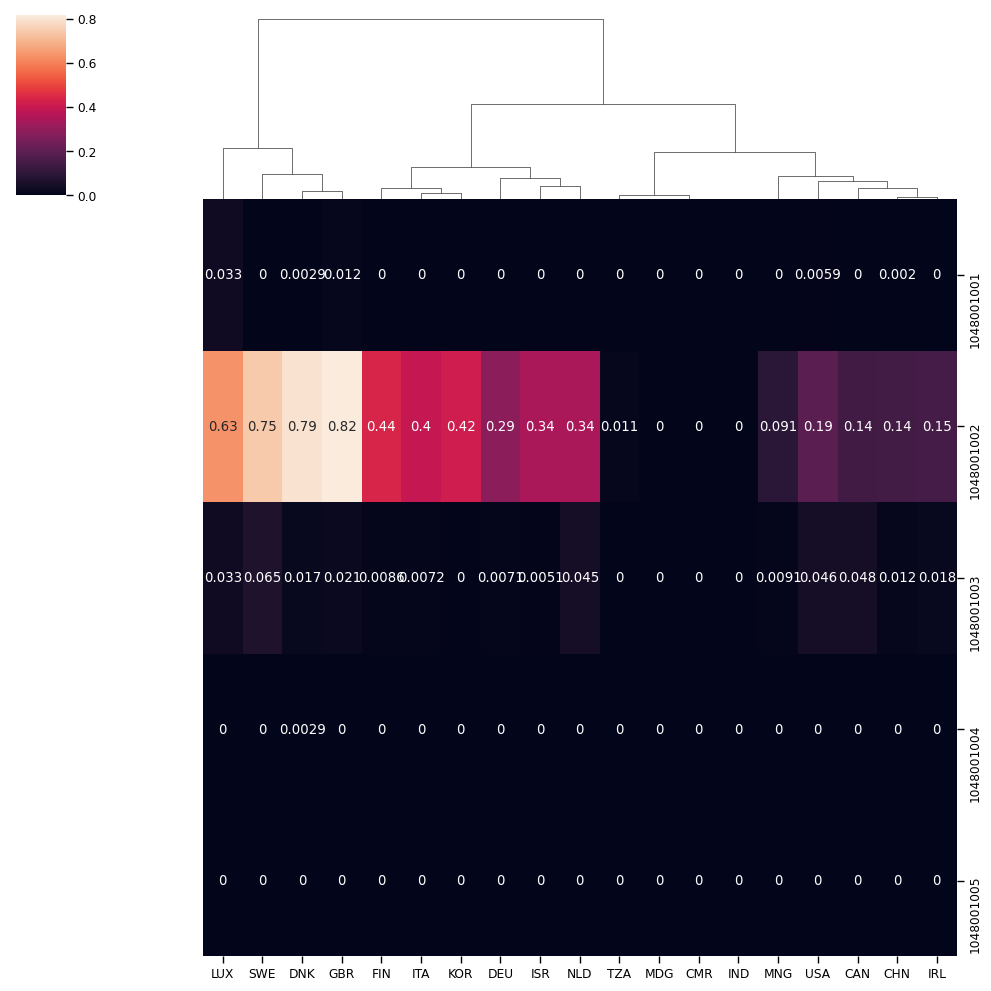

In [81]:
plt.figure(figsize=(12,8))
sns.clustermap(plot_df.loc[plot_df.index.str.startswith("1048")], annot=True, row_cluster=False)

In [140]:
#result.to_csv("countries_comparison.tsv",sep='\t',index=False)

In [589]:
result['cluster95'] = result['subspecies'].str[:4]

In [590]:
result.query("(cluster95 == '0011') & (group1 == 'CAN') & (group2 == '')")

Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject, subspecies, cluster95]
Index: []

In [591]:
from itertools import combinations

In [176]:
result.loc[(result['subspecies'] == '0001001001') & (result['group1'] == 'ITA')]

group1 group2  meandiff   p-adj   lower   upper  reject  subspecies  \
135    ITA    KOR   -0.4010  0.0006 -0.7048 -0.0971    True  0001001001   
136    ITA    LUX    0.0768  1.0000 -0.2502  0.4038   False  0001001001   
137    ITA    MDG   -0.5505 -0.0000 -0.7580 -0.3430    True  0001001001   
138    ITA    MNG   -0.5141 -0.0000 -0.7216 -0.3066    True  0001001001   
139    ITA    NLD   -0.1307  0.9255 -0.3724  0.1111   False  0001001001   
140    ITA    SWE   -0.0078  1.0000 -0.1941  0.1785   False  0001001001   
141    ITA    TZA   -0.5096 -0.0000 -0.7310 -0.2881    True  0001001001   
142    ITA    USA   -0.1447  0.0553 -0.2908  0.0013   False  0001001001   

    cluster95  
135      0001  
136      0001  
137      0001  
138      0001  
139      0001  
140      0001  
141      0001  
142      0001

In [190]:
prevalence_df.loc[(prevalence_df['country'] == 'USA') & (prevalence_df['subspecies'] == '0001001001')]['presence'].sum() / prevalence_df.loc[(prevalence_df['country'] == 'USA') & (prevalence_df['subspecies'] == '0001001001')].shape[0]

0.47844463229078615

In [189]:
prevalence_df.loc[(prevalence_df['country'] == 'ITA') & (prevalence_df['subspecies'] == '0001001001')]['presence'].sum() / prevalence_df.loc[(prevalence_df['country'] == 'ITA') & (prevalence_df['subspecies'] == '0001001001')].shape[0]

0.6231884057971014

In [187]:
prevalence_df.loc[(prevalence_df['country'] == 'ITA') & (prevalence_df['subspecies'] == '1073001002')]['presence'].sum() / prevalence_df.loc[(prevalence_df['country'] == 'MDG') & (prevalence_df['subspecies'] == '1073001002')].shape[0]

0.4090909090909091

In [191]:
result.loc[(result['subspecies'] == '0001001001') & (result['group1'] == 'ITA')]

group1 group2  meandiff   p-adj   lower   upper  reject  subspecies  \
135    ITA    KOR   -0.4010  0.0006 -0.7048 -0.0971    True  0001001001   
136    ITA    LUX    0.0768  1.0000 -0.2502  0.4038   False  0001001001   
137    ITA    MDG   -0.5505 -0.0000 -0.7580 -0.3430    True  0001001001   
138    ITA    MNG   -0.5141 -0.0000 -0.7216 -0.3066    True  0001001001   
139    ITA    NLD   -0.1307  0.9255 -0.3724  0.1111   False  0001001001   
140    ITA    SWE   -0.0078  1.0000 -0.1941  0.1785   False  0001001001   
141    ITA    TZA   -0.5096 -0.0000 -0.7310 -0.2881    True  0001001001   
142    ITA    USA   -0.1447  0.0553 -0.2908  0.0013   False  0001001001   

    cluster95  
135      0001  
136      0001  
137      0001  
138      0001  
139      0001  
140      0001  
141      0001  
142      0001

In [178]:
result.loc[(result['subspecies'] == '0001001005') & (result['group1'] == 'ITA')]

group1 group2  meandiff   p-adj   lower   upper  reject  subspecies  \
135    ITA    KOR   -0.0024  1.0000 -0.2536  0.2487   False  0001001005   
136    ITA    LUX   -0.0246  1.0000 -0.2950  0.2457   False  0001001005   
137    ITA    MDG   -0.7186 -0.0000 -0.8901 -0.5471    True  0001001005   
138    ITA    MNG    0.0087  1.0000 -0.1628  0.1802   False  0001001005   
139    ITA    NLD   -0.0406  1.0000 -0.2404  0.1593   False  0001001005   
140    ITA    SWE   -0.0392  1.0000 -0.1932  0.1147   False  0001001005   
141    ITA    TZA   -0.6299 -0.0000 -0.8130 -0.4469    True  0001001005   
142    ITA    USA   -0.1542  0.0011 -0.2749 -0.0335    True  0001001005   

    cluster95  
135      0001  
136      0001  
137      0001  
138      0001  
139      0001  
140      0001  
141      0001  
142      0001

In [587]:
result = result.reset_index(drop=True)

In [592]:
significant_results = []

for cluster95 in result['cluster95'].unique():
    df = result.query("cluster95 == @cluster95")
    if df['subspecies'].nunique() > 1:
        for country_pair in combinations(metadata.country.unique(),2):
            temp_df = df.loc[(df.group1 == country_pair[0]) & (df.group2 == country_pair[1])]
            if temp_df['reject'].sum() > 1:
                if (temp_df['meandiff'].iloc[0] > 0) and (temp_df['meandiff'].iloc[1] < 0):
                    significant_results.extend(temp_df.index)
                    #print(f"Species {cluster95}: look at the countries {country_pair}")
                    #significant_results.append()
                elif (temp_df['meandiff'].iloc[0] < 0) and (temp_df['meandiff'].iloc[1] > 0):
                    #print(f"Species {cluster95}: look at the countries {country_pair}")
                    significant_results.extend(temp_df.index)
            elif temp_df['reject'].sum() == 1:
                #print(f"Species {cluster95}: look at the countries {country_pair}")
                significant_results.extend(temp_df.index)
                #significant_results.append((cluster95, country_pair[0], country_pair[1]))

In [593]:
significant_results = result.iloc[significant_results]

In [594]:
significant_results.loc[abs(significant_results['meandiff']) > 0.1]['cluster95'].nunique()

54

In [619]:
significant_results.loc[significant_results.cluster95 == '0103']

group1         group2  meandiff   p-adj   lower   upper  reject  \
107  Europe  North America   -0.0139  0.3742 -0.0361  0.0083   False   
113  Europe  North America    0.0026  0.5996 -0.0027  0.0078   False   
119  Europe  North America   -0.3756 -0.0000 -0.4171 -0.3341    True   

     subspecies cluster95  
107  0103001001      0103  
113  0103001002      0103  
119  0103001003      0103

In [602]:
significant_results.sort_values(by='meandiff')

group1         group2  meandiff   p-adj   lower   upper  reject  \
4307   Europe  North America   -0.3995 -0.0000 -0.4399 -0.3590    True   
10259  Europe  North America   -0.3779 -0.0000 -0.4208 -0.3349    True   
119    Europe  North America   -0.3756 -0.0000 -0.4171 -0.3341    True   
11189  Europe  North America   -0.3571 -0.0000 -0.3993 -0.3150    True   
8327   Europe  North America   -0.3519 -0.0000 -0.3941 -0.3098    True   
...       ...            ...       ...     ...     ...     ...     ...   
2915   Europe  North America    0.0504 -0.0000  0.0376  0.0632    True   
899    Europe  North America    0.0552 -0.0000  0.0452  0.0652    True   
23     Europe  North America    0.0590  0.0000  0.0346  0.0833    True   
6995   Europe  North America    0.0671  0.0003  0.0244  0.1097    True   
4301   Europe  North America    0.1109 -0.0000  0.0882  0.1335    True   

       subspecies cluster95  
4307   2050001004      2050  
10259  0511001001      0511  
119    0103001003      0103  
11189  0785001001      0785  
8327   0346001002      0346  
...           ...       ...  
2915   1710001001      1710  
899    1296001003      1296  
23     1005001001      1005  
6995   0291001005      0291  
4301   2050001002      2050  

[350 rows x 9 columns]

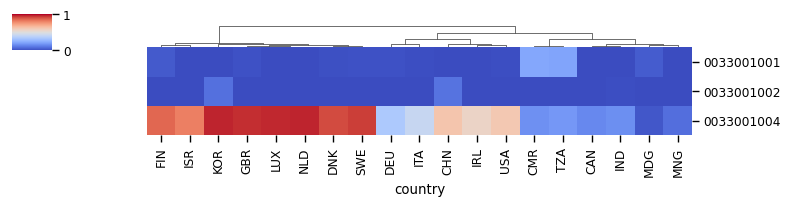

In [45]:
sns.set_context('paper')
sns.clustermap(prevalence.loc[prevalence.index.str.startswith("0033")], annot=False, row_cluster=False,figsize=(8,2),cmap='coolwarm',vmin=0,vmax=1)

In [611]:
full_subsp_def = pd.read_csv('/Users/trickovi/switchdrive/kmer_analysis/fullname_subsp_def_sourmash.txt',sep='\t')
full_subsp_def['subspecies'] = full_subsp_def['subspecies'].astype(str).str.rjust(10,'0')

In [617]:
full_subsp_def.loc[full_subsp_def['subspecies'] == '0291001005'].shape[0]

1

# Distribution of species

In [657]:
merged_df_sp = merged_df.copy()

merged_df_sp_country = merged_df_sp['country']
merged_df_sp = merged_df_sp.drop('country', axis=1)

merged_df_sp.columns = merged_df_sp.columns.str[:4]

merged_df_sp = merged_df_sp.groupby(level=0,axis=1).sum()

merged_df_sp = merged_df_sp.mask(merged_df_sp >=1, 1)
merged_df_sp['country'] = merged_df_sp_country

In [660]:
# Calculate the number of occurrences for each subspecies per country
num_occurrences_sp = merged_df_sp.groupby('country').sum()

# Calculate the number of samples per country
num_samples = merged_df_sp['country'].value_counts()

prevalence_sp = num_occurrences_sp.T / num_samples

In [672]:
absent_species = (prevalence_sp == 0).sum(1).loc[(prevalence_sp == 0).sum(1) == 4].index

prevalence_sp = prevalence_sp.loc[~prevalence_sp.index.isin(absent_species)]

In [698]:
prevalence_df_sp = mastiff.reset_index().melt(id_vars='sample')
prevalence_df_sp['variable'] = prevalence_df_sp['variable'].str[:4]
prevalence_df_sp = prevalence_df_sp.groupby(["sample", "variable"]).sum().reset_index()

prevalence_df_sp['value'] = prevalence_df_sp['value'].mask(prevalence_df_sp['value'] >=1, 1)

In [699]:
prevalence_df_sp = prevalence_df_sp.merge(metadata,left_on = 'sample',right_index=True).reset_index(drop=True)
prevalence_df_sp = prevalence_df_sp.rename(columns={'variable':'species', 'value':'presence'})

In [706]:
result_sp = chi_square_test(prevalence_df_sp, variable='species')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1743/1743 [12:55<00:00,  2.25it/s]


Variable: species, corrected p-value: 2.473230332004923e-255
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 7.732780363188457e-29
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 2.9439620020313036e-71
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 5.963490057621588e-45
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 2.5196199411222573e-47
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 5.345469700714332e-85
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 2.2580558705239767e-28
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-value: 5.644685401952656e-150
Significant result for species. Performing post-hoc test...
Variable: species, corrected p-valu

In [710]:
result_sp.groupby("species")['reject'].all()

species
0001    False
0002    False
0003    False
0004    False
0005    False
        ...  
5113    False
5121    False
5138    False
5142    False
5151    False
Name: reject, Length: 1314, dtype: bool

In [716]:
result_sp.loc[result_sp['species'] == '0004']

group1         group2  meandiff   p-adj   lower   upper  reject species
0  Africa           Asia    0.0034  0.9984 -0.0498  0.0566   False    0004
1  Africa         Europe    0.0273  0.5229 -0.0241  0.0787   False    0004
2  Africa  North America   -0.1260  0.0000 -0.1798 -0.0723    True    0004
3    Asia         Europe    0.0238  0.0851 -0.0021  0.0498   False    0004
4    Asia  North America   -0.1295 -0.0000 -0.1599 -0.0991    True    0004
5  Europe  North America   -0.1533 -0.0000 -0.1804 -0.1262    True    0004

In [934]:
Tax.query("cluster95 == @all_sig_subspecies[17]").drop_duplicates().iloc[0]['species'].strip("s__")

'CAG-83 sp000435555'

In [913]:
prevalence_sp_plotting = prevalence_sp.copy()

In [915]:
prevalence_sp_plotting.index.map()

Africa      Asia    Europe  North America
0001  0.263158  0.923803  0.950061       0.901163
0002  0.020243  0.337446  0.364306       0.276578
0003  0.680162  0.808418  0.955792       0.799834
0004  0.910931  0.914369  0.938191       0.784884
0005  0.785425  0.854862  0.936963       0.769934
...        ...       ...       ...            ...
5131  0.000000  0.000000  0.000409       0.000831
5138  0.000000  0.000000  0.004093       0.000000
5142  0.008097  0.000726  0.000000       0.000000
5151  0.076923  0.000000  0.001228       0.000000
5157  0.000000  0.000000  0.000409       0.000000

[1659 rows x 4 columns]

[None, None]

<Figure size 864x576 with 0 Axes>

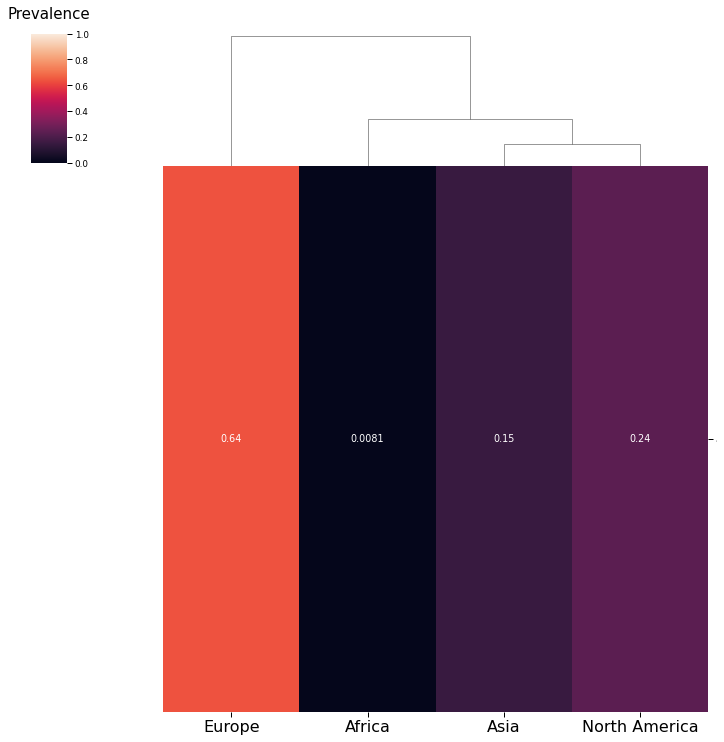

In [981]:
#species = all_sig_subspecies[19]
species = '0174'

sns.set_context('paper')

plt.figure(figsize=(12,8))
g = sns.clustermap(prevalence_sp.loc[prevalence_sp.index.str.startswith(species)], annot=True, row_cluster=False, vmin=0, vmax=1)
g.cax.set_title("Prevalence", fontsize=15, pad =15)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=16)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=0)

[None, None, None, None]

<Figure size 864x576 with 0 Axes>

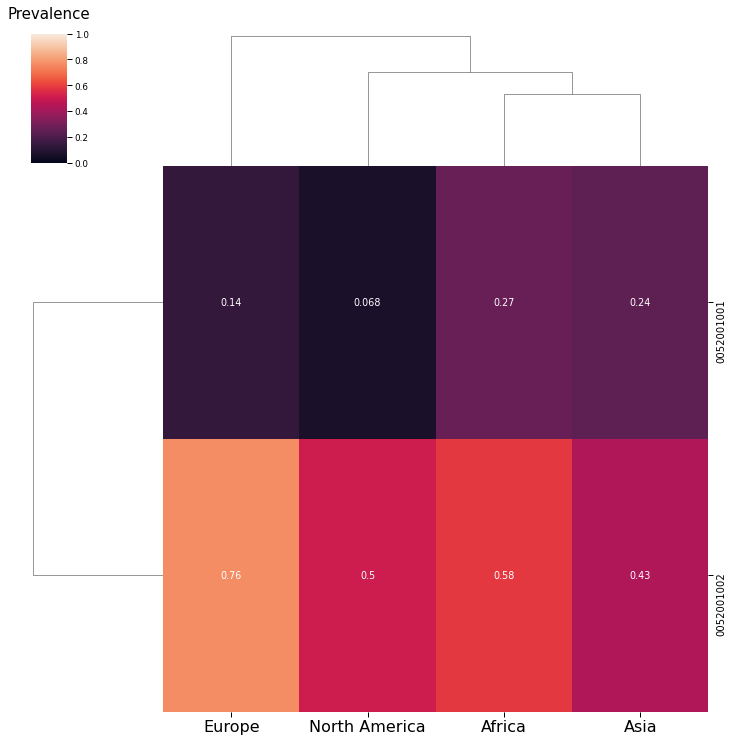

In [985]:
plt.figure(figsize=(12,8))
g = sns.clustermap(plot_df.loc[plot_df.index.str.startswith('0052')], vmin=0,vmax=1, annot=True)
#g = sns.clustermap(plot_df.loc[plot_df.index.str.startswith('0024')], vmin=0,vmax=1, annot=True)


g.cax.set_title("Prevalence", fontsize=15, pad =15)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=16)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)

In [958]:
result.loc[result.cluster95 == '0024'].query('subspecies == "0004001001"')

Empty DataFrame
Columns: [group1, group2, meandiff, p-adj, lower, upper, reject, subspecies, cluster95]
Index: []

In [857]:
comparisons = [('Africa','Asia'),('Africa','Europe'),('Africa','North America'),('Asia','Europe'),('Asia','North America'),('Europe','North America')]

all_sig_subspecies = []

for comparison in comparisons:
    sig_species = result_sp.loc[(result_sp['group1'] == comparison[0]) & (result_sp['group2'] == comparison[1])].query("reject == True")['species'].to_list()
    sig_subsp = result.loc[(result['group1'] == comparison[0]) & (result['group2'] == comparison[1])].query("reject == True")
    sig_subsp = sig_subsp.loc[~sig_subsp['cluster95'].isin(sig_species)]['cluster95'].unique()
    all_sig_subspecies.extend(sig_subsp)

all_sig_subspecies = list(set(all_sig_subspecies))

<Figure size 864x576 with 0 Axes>

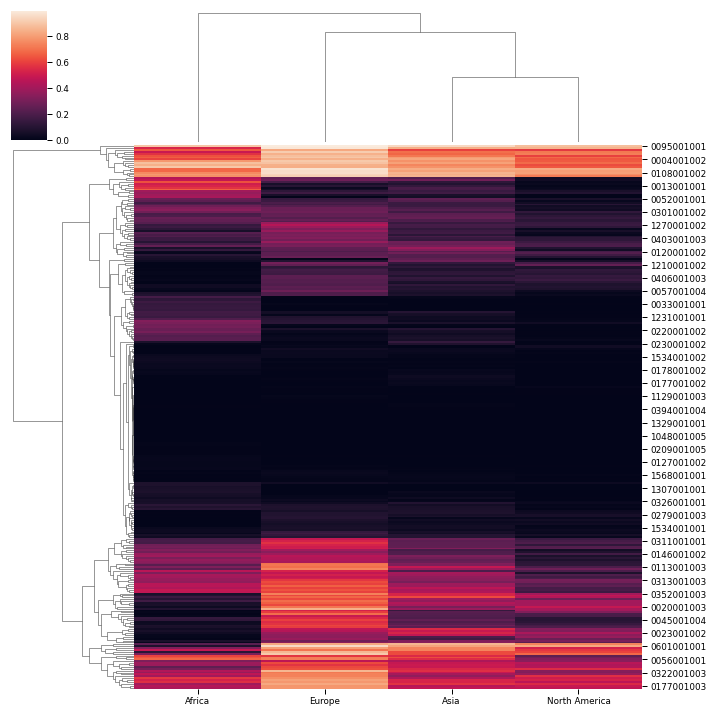

In [858]:
plt.figure(figsize=(12,8))
sns.clustermap(plot_df.loc[plot_df.index.str.startswith(tuple(all_sig_subspecies))])

In [976]:
all_sig_subspecies[19]

'0411'

In [980]:
Tax.loc[Tax.cluster95 == '0411']

kindom               phylum              class  \
5198  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
5307  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
5430  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
7689  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
8311  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
8385  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   
9286  d__Bacteria  p__Actinobacteriota  c__Coriobacteriia   

                    order                family           genus  \
5198  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
5307  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
5430  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
7689  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
8311  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
8385  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   
9286  o__Coriobacteriales  f__Coriobacteriaceae  g__Collinsella   

                         species cluster95  
5198  s__Collinsella sp003436275      0411  
5307                         NaN      0411  
5430  s__Collinsella sp900541685      0411  
7689                         NaN      0411  
8311  s__Collinsella sp003459245      0411  
8385                         NaN      0411  
9286  s__Collinsella sp003469205      0411

In [977]:
result.loc[result.cluster95 == '0411']#.query("group1 == 'Africa'").query("group2 == 'Asia'")

group1         group2  meandiff   p-adj   lower   upper  reject  \
9312  Africa           Asia   -0.0819  0.0381 -0.1606 -0.0031    True   
9313  Africa         Europe    0.0657  0.1189 -0.0105  0.1418   False   
9314  Africa  North America   -0.2369 -0.0000 -0.3165 -0.1572    True   
9315    Asia         Europe    0.1475 -0.0000  0.1091  0.1859    True   
9316    Asia  North America   -0.1550 -0.0000 -0.2000 -0.1101    True   
9317  Europe  North America   -0.3025 -0.0000 -0.3427 -0.2624    True   
9318  Africa           Asia   -0.0423  0.5569 -0.1254  0.0407   False   
9319  Africa         Europe    0.0838  0.0366  0.0036  0.1641    True   
9320  Africa  North America   -0.2355 -0.0000 -0.3195 -0.1516    True   
9321    Asia         Europe    0.1262 -0.0000  0.0857  0.1667    True   
9322    Asia  North America   -0.1932 -0.0000 -0.2406 -0.1458    True   
9323  Europe  North America   -0.3194 -0.0000 -0.3617 -0.2770    True   

      subspecies cluster95  
9312  0411001001      0411  
9313  0411001001      0411  
9314  0411001001      0411  
9315  0411001001      0411  
9316  0411001001      0411  
9317  0411001001      0411  
9318  0411001002      0411  
9319  0411001002      0411  
9320  0411001002      0411  
9321  0411001002      0411  
9322  0411001002      0411  
9323  0411001002      0411

In [978]:
result_sp.loc[result_sp.species == '0411']#.query("group1 == 'Africa'").query("group2 == 'Asia'")

group1         group2  meandiff   p-adj   lower   upper  reject species
0  Africa           Asia   -0.0409  0.5872 -0.1241  0.0423   False    0411
1  Africa         Europe    0.0920  0.0173  0.0116  0.1724    True    0411
2  Africa  North America   -0.2314  0.0000 -0.3155 -0.1473    True    0411
3    Asia         Europe    0.1329 -0.0000  0.0923  0.1735    True    0411
4    Asia  North America   -0.1905 -0.0000 -0.2380 -0.1430    True    0411
5  Europe  North America   -0.3234 -0.0000 -0.3658 -0.2810    True    0411

In [954]:
full_subsp_def.loc[full_subsp_def['subspecies'].str.startswith('0052')]['subspecies'].value_counts()

0052001001    161
0052001002    110
0052001003      1
Name: subspecies, dtype: int64

In [832]:
pd.read_csv("/Users/trickovi/switchdrive/mastiff/metadata_by_sample.tsv",sep='\t',index_col=0)['Location'].value_counts()

North America    2801
Europe           2631
Asia             1408
South America      36
Oceania            24
Africa             21
Name: Location, dtype: int64

In [938]:
"0024" in all_sig_subspecies

True

In [940]:
"0052" in all_sig_subspecies

True